In [108]:
import matplotlib.pyplot as plt
import numpy as np
import pretty_midi
import librosa

In [109]:
input_path = "mp3_input/bass_NGHYB_clean_20_seconds.mp3"
output_path = "transcribed_output/bass_output.mid"

audio, sr = librosa.load(input_path)

In [ ]:
hop_length = 512 # default
# hop_length = 700

In [111]:
f0 = librosa.yin(y=audio, fmin=40, fmax=400, sr=sr)
times = librosa.frames_to_time(np.arange(len(f0)), sr=sr, hop_length=hop_length)

In [112]:
# Convert frequencies → MIDI notes
def hz_to_midi(hz):
    if hz <= 0 or np.isnan(hz):
        return None
    return int(round(69 + 12 * np.log2(hz / 440.0)))

midi_notes = [hz_to_midi(freq) for freq in f0]

In [113]:
print(midi_notes)

[39, 35, 34, 34, 33, 34, 29, 29, 34, 34, 34, 34, 34, 35, 35, 35, 37, 28, 28, 28, 48, 27, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 29, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 34, 35, 39, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,

In [114]:
print(len(times))
print(len(midi_notes))

862
862


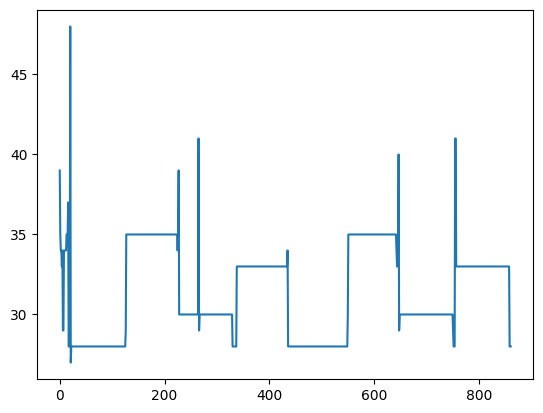

In [115]:
plt.plot(midi_notes)

In [116]:
noise_window = 1

# build midi from sequence of midi notes 
# Build MIDI file
midi = pretty_midi.PrettyMIDI()
bass_program = pretty_midi.instrument_name_to_program("Acoustic Bass")
bass = pretty_midi.Instrument(program=bass_program)

# Group frames into sustained notes
current_note = None
note_start = None

for i, note in enumerate(midi_notes):
    if note is not None:
        if current_note is None:  # new note
            current_note = note
            note_start = times[i]
        elif not((current_note - noise_window) < note < (current_note + noise_window)):  # pitch change → close old note, start new
            bass.notes.append(pretty_midi.Note(
                velocity=100, pitch=current_note,
                start=note_start, end=times[i]
            ))
            current_note = note
            note_start = times[i]
    else:
        if current_note is not None:  # end current note
            bass.notes.append(pretty_midi.Note(
                velocity=100, pitch=current_note,
                start=note_start, end=times[i]
            ))
            current_note = None
            note_start = None

# If song ends with a note still playing
if current_note is not None:
    bass.notes.append(pretty_midi.Note(
        velocity=100, pitch=current_note,
        start=note_start, end=times[-1]
    ))

midi.instruments.append(bass)

In [117]:
bass.notes

[Note(start=0.000000, end=0.031746, pitch=39, velocity=100),
 Note(start=0.031746, end=0.063492, pitch=35, velocity=100),
 Note(start=0.063492, end=0.126984, pitch=34, velocity=100),
 Note(start=0.126984, end=0.158730, pitch=33, velocity=100),
 Note(start=0.158730, end=0.190476, pitch=34, velocity=100),
 Note(start=0.190476, end=0.253968, pitch=29, velocity=100),
 Note(start=0.253968, end=0.412698, pitch=34, velocity=100),
 Note(start=0.412698, end=0.507937, pitch=35, velocity=100),
 Note(start=0.507937, end=0.539683, pitch=37, velocity=100),
 Note(start=0.539683, end=0.634921, pitch=28, velocity=100),
 Note(start=0.634921, end=0.666667, pitch=48, velocity=100),
 Note(start=0.666667, end=0.698413, pitch=27, velocity=100),
 Note(start=0.698413, end=4.000000, pitch=28, velocity=100),
 Note(start=4.000000, end=4.031746, pitch=29, velocity=100),
 Note(start=4.031746, end=7.142857, pitch=35, velocity=100),
 Note(start=7.142857, end=7.174603, pitch=34, velocity=100),
 Note(start=7.174603, en

In [118]:
# midi.write(output_path)